# sspa tutorial: Single sample pathway analysis in Python

In [1]:
import sspa
import seaborn as sns
import matplotlib.pyplot as plt

## Using example data (metabolomics)

In [4]:
# We will import the metabolite pathways from the Reactome database
# We must specify one of the Reactome organism names
# This a GMT format pandas DataFrame containing the pathway information
reactome_pathways  = sspa.ProcessPathways(infile="R78").process_reactome(organism="Homo sapiens")

In [5]:
reactome_pathways

,Pathway_name,0,1,2,3,4,5,6,7,8,...,1637,1638,1639,1640,1641,1642,1643,1644,1645,1646
R-HSA-1059683,Interleukin-6 signaling,30616,456216,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109581,Apoptosis,15377,16412,28494,30616,None,36080,None,43474,456216,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109582,Hemostasis,140420,140421,140427,140472,142430,142431,142432,142433,142435,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109606,Intrinsic Pathway for Apoptosis,15377,28494,30616,None,36080,43474,456216,None,None,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109703,PKB-mediated events,15377,16618,17489,30616,456215,456216,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R-HSA-983695,Antigen activates B Cell Receptor (BCR) leadin...,16595,None,16618,None,17815,18348,29108,None,30616,...,None,None,None,None,None,None,None,None,None,None
R-HSA-983705,Signaling by the B Cell Receptor (BCR),16595,None,16618,None,17815,None,18303,18348,29034,...,None,None,None,None,None,None,None,None,None,None
R-HSA-983712,Ion channel transport,15377,15378,None,16038,17544,17775,17996,None,18303,...,None,None,None,None,None,None,None,None,None,None
R-HSA-991365,Activation of GABAB receptors,17552,18420,None,29103,37565,None,43474,58189,59888,...,None,None,None,None,None,None,None,None,None,None


In [3]:
# We will now load some example metabolomics data which has already been pre-processed
# The example data is in the form of a pandas DataFrame
example_data = sspa.load_example_data(omicstype="metabolomics")

In [4]:
example_data

,1372,16610,72665,27823,30915,37373,16831,545959,17050,16359,...,133693,133694,28036,28238,76341,89312,17861,89188,WHO_status,Group
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,-0.822470,0.370169,0.537246,0.362243,-0.578361,-1.201938,-1.195697,-0.253528,0.237192,-0.502347,...,0.057068,0.228500,-0.546769,-0.587946,-0.175542,-0.693254,-1.201150,0.403074,0,Healthy Donor
1008097,0.149291,-0.802638,-1.220563,-0.774417,-0.123663,-0.453530,-0.956306,-0.805678,-0.840364,0.320534,...,0.565895,0.544281,-0.053133,-0.048306,-0.920090,-1.434730,-0.475391,0.134784,0,Healthy Donor
1008631,1.012771,-1.033291,0.145690,0.524050,-0.073503,-0.229649,1.475643,-0.437623,-0.827898,-0.462676,...,0.507601,1.009191,0.099614,0.508498,-1.272854,0.448616,1.207374,-0.637957,0,Healthy Donor
1012545,-0.979554,-0.395854,2.449097,0.866752,-0.354040,-0.345205,0.057663,-0.306422,-0.908367,-0.533817,...,-0.091666,0.782065,-0.341433,1.612615,0.851680,-0.504009,0.084370,-0.279907,0,Healthy Donor
1022407,-0.739817,-0.288710,-0.782552,-0.526128,0.288048,0.550284,-0.550971,-0.640346,-0.833565,-0.451067,...,0.233939,0.883763,-0.576132,-0.567979,-1.182109,-0.260231,-1.009292,-0.095161,0,Healthy Donor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135-BL,-2.228940,-0.101002,-0.679609,0.000163,0.284214,0.734004,-0.041038,-0.210435,0.070459,-0.374044,...,-0.525115,-0.495566,-0.182214,0.714288,-0.265526,-0.151931,1.330576,-1.105986,1-2,COVID19
INCOV136-BL,-0.169748,1.599117,0.173275,0.046243,-0.470655,1.219268,0.504222,1.204577,2.016911,0.431724,...,-0.768909,-0.829643,-0.247622,-1.579635,0.567450,-0.364475,1.220314,-0.755291,3-4,COVID19
INCOV137-BL,0.317113,0.383352,-0.981562,0.857227,-1.462299,0.594609,0.561018,-0.709397,0.361510,-0.550916,...,-1.380566,-1.338709,2.431694,0.961980,0.630608,-0.262134,0.475143,-1.235598,5-7,COVID19


In [5]:
example_data.iloc[:, :-2].shape

(263, 333)

Using kPCA method

In [6]:
kpca_scores = sspa.sspa_kpca(example_data.iloc[:, :-2], reactome_pathways)

In [7]:
# Inspect the pathway score matrix
kpca_scores

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112314,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,...,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-975634
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,-0.502078,-0.132625,0.396203,-0.428671,-0.476686,0.441486,0.441486,-0.589968,0.510460,0.510460,...,-0.183712,-0.183712,-0.183712,-0.372311,0.510460,-0.422047,-0.345804,-0.354446,-0.301712,0.591590
1008097,-0.129990,-0.066326,0.391151,-0.406094,-0.518504,0.299533,0.299533,-0.473981,-0.468032,-0.468032,...,-0.338553,-0.338553,-0.338553,0.084853,-0.468032,-0.196016,-0.036367,-0.388074,-0.342489,-0.647908
1008631,-0.440406,-0.635373,0.532148,-0.304056,0.119538,0.409759,0.409759,-0.516610,-0.485141,-0.485141,...,-0.188555,-0.188555,-0.188555,0.253315,-0.485141,0.057013,0.189092,0.005851,-0.006643,-0.637767
1012545,-0.510654,-0.006082,0.194296,-0.233943,-0.137645,0.279338,0.279338,0.483868,0.276672,0.276672,...,-0.360939,-0.360939,-0.360939,-0.462326,0.276672,0.055994,-0.501358,0.281106,0.260653,0.323059
1022407,-0.466940,-0.489754,0.240493,-0.503301,0.237958,0.383802,0.383802,-0.291602,0.375111,0.375111,...,-0.353277,-0.353277,-0.353277,-0.303643,0.375111,-0.457766,-0.327138,-0.439894,-0.356451,0.386204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135-BL,0.413898,0.623289,0.088663,-0.017805,-0.135851,0.161592,0.161592,0.378288,-0.489231,-0.489231,...,-0.303870,-0.303870,-0.303870,0.209797,-0.489231,-0.192039,0.219603,-0.320906,-0.403381,-0.586796
INCOV136-BL,0.301070,0.507104,-0.375875,0.570154,0.009647,-0.375421,-0.375421,0.623957,0.403879,0.403879,...,0.266371,0.266371,0.266371,-0.112053,0.403879,-0.345653,0.095706,-0.320380,-0.319519,0.647968
INCOV137-BL,0.291807,0.629146,-0.329863,0.441748,-0.121469,-0.363859,-0.363859,0.417775,-0.504907,-0.504907,...,-0.022882,-0.022882,-0.022882,0.593205,-0.504907,0.373511,0.230926,0.399491,0.400392,-0.568340


/Users/cw2019/opt/anaconda3/envs/py10/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


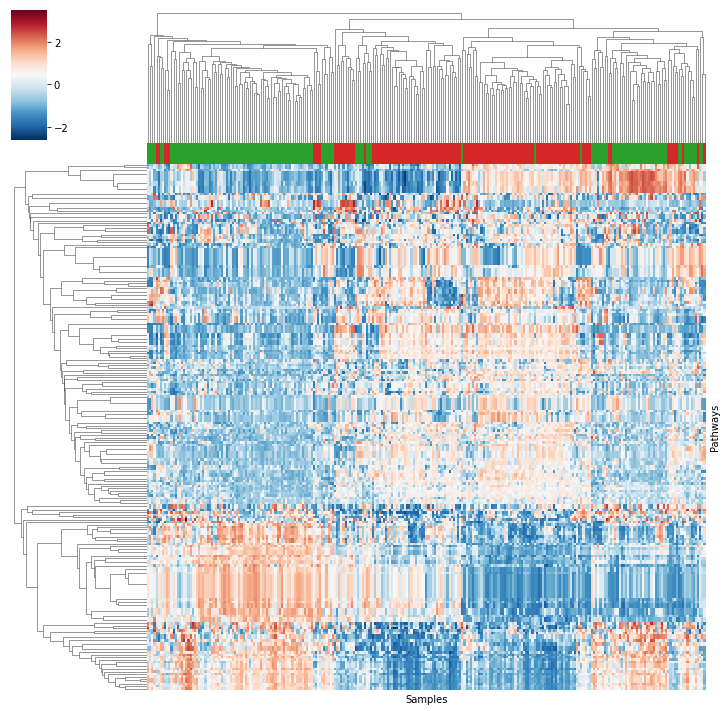

In [8]:
# Plot a heatmap using the pathway scores
g = sns.clustermap(kpca_scores.T,
               cmap="RdBu_r",
               z_score=1,
              col_colors = ["tab:red" if i == "COVID19 " else "tab:green" for i in example_data["Group"]],
              xticklabels=False,
              yticklabels=False)
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Pathways")
plt.show()

Using ssClustPA method

In [9]:
ssclustpa_res = sspa.sspa_cluster(example_data.iloc[:, :-2], reactome_pathways)

In [10]:
ssclustpa_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112314,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,...,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-975634
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,0.686092,1.231206,1.672909,1.199419,2.203191,3.172926,3.172926,0.875834,1.988715,0.578927,...,1.497666,3.412581,3.412581,1.058583,1.994707,1.115001,2.299242,2.417228,0.888711,0.513695
1008097,1.227926,0.938665,3.290234,1.477871,2.445170,3.219696,3.219696,0.146031,0.577443,2.389911,...,0.994147,2.956051,2.956051,1.909893,0.587010,2.246284,2.486446,3.296610,0.909019,2.327286
1008631,0.923137,0.588778,2.375251,0.958269,2.398839,1.922489,1.922489,0.675890,0.440770,2.322971,...,0.996719,2.247359,2.247359,1.877146,0.450025,2.666199,1.398663,1.583694,1.464408,2.286247
1012545,1.335768,2.001108,1.729395,2.018233,1.704514,3.845707,3.845707,1.656992,1.941054,1.705760,...,0.970014,2.783308,2.783308,1.425182,1.956087,2.926738,3.329176,3.083823,2.485732,0.867966
1022407,1.424180,0.313960,1.374500,0.809786,2.655825,3.373692,3.373692,0.224111,1.585746,0.983527,...,0.776872,2.897329,2.897329,0.847578,1.595144,1.049190,2.200257,2.817698,0.431612,0.870463


Using ssClustPA(proj) method

In [10]:
ssclustpa_proj_res = sspa.sspa_cluster(example_data.iloc[:, :-2], reactome_pathways, projection=True)
ssclustpa_proj_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112314,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,...,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-975634
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,1.137223,-0.612266,1.202925,1.058390,0.231663,-1.178091,-1.186966,1.503746,-1.003367,-1.003367,...,1.127729,1.127729,1.127729,0.692002,1.003367,1.021009,0.797385,0.264491,-0.470581,-1.001937
1008097,1.242406,-0.233183,-0.812831,2.070620,0.366747,0.296890,0.281255,0.777702,1.109737,1.109737,...,0.795619,0.795619,0.795619,-0.302023,-1.109737,-0.022997,0.359072,1.266075,-0.799732,1.103654
1008631,0.669636,-1.473881,-0.643448,0.371524,0.504319,0.563481,0.550725,1.029775,1.067348,1.067348,...,0.053606,0.053606,0.053606,-0.570519,-1.067348,-1.219965,-0.340290,-0.714006,0.393791,1.062813
1012545,0.973549,-0.465256,1.307151,1.257698,-0.186664,-1.561800,-1.566948,-0.426893,-0.342733,-0.342733,...,0.605926,0.605926,0.605926,1.560709,0.342733,0.752879,1.924766,-0.093753,-0.074002,-0.360651
1022407,1.311975,-0.707896,1.310502,1.465829,0.759903,-1.580583,-1.596556,0.534112,-0.513847,-0.513847,...,0.803873,0.803873,0.803873,0.561108,0.513847,0.976420,0.785223,0.788806,-0.611825,-0.517576


Using z-score method

In [4]:
zscore_res = sspa.sspa_zscore(example_data.iloc[:, :-2], reactome_pathways)

In [5]:
zscore_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112314,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,...,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-975634
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,-0.167654,-0.634281,-1.195573,-1.010589,-0.092788,-0.909283,-0.909283,-1.465189,0.658852,0.658852,...,-0.254058,-0.254058,-0.254058,0.588049,0.658852,0.230005,0.164385,-0.386723,-0.427604,0.993357
1008097,-1.397061,-0.245093,-2.396622,-2.046443,-0.147668,-2.395123,-2.395123,-0.769212,-0.583845,-0.583845,...,-0.342975,-0.342975,-0.342975,-0.119131,-0.583845,-0.435729,-0.709389,-0.006923,-0.327141,-1.101735
1008631,0.461736,-1.477089,-1.406400,-0.336006,-0.529297,-1.241239,-1.241239,-0.919933,-0.626855,-0.626855,...,-0.616980,-0.616980,-0.616980,-0.436981,-0.626855,-0.999337,-0.450087,-0.561914,-0.515378,-1.061005
1012545,0.701684,-0.429032,-0.038955,-1.115958,0.160970,-0.316692,-0.316692,0.200689,1.142506,1.142506,...,-0.713366,-0.713366,-0.713366,1.730048,1.142506,0.443188,1.201164,1.027331,1.137367,0.358604
1022407,-0.112825,-0.703408,-0.005595,-1.447454,-0.784849,-0.564315,-0.564315,-0.560817,0.696354,0.696354,...,-0.870950,-0.870950,-0.870950,0.545654,0.696354,-0.014220,0.094409,0.056086,-0.243176,0.526767


Using SVD (PLAGE) method

In [7]:
svd_res = sspa.sspa_svd(example_data.iloc[:, :-2], reactome_pathways)
svd_res.head()

,R-HSA-109582,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112314,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,...,R-HSA-9660821,R-HSA-9662851,R-HSA-9664433,R-HSA-9707564,R-HSA-9707616,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-975634
sample_id,,,,,,,,,,,,,,,,,,,,,
1004596,0.053439,0.034742,-0.024311,0.034779,0.005188,0.023736,0.023736,0.077489,-0.045696,-0.045696,...,-0.021656,-0.021656,-0.021656,-0.043171,-0.045696,-0.038112,-0.050812,-0.015621,-0.017493,-0.044859
1008097,0.063985,0.013425,0.050263,0.087979,0.008256,-0.023342,-0.023342,0.040681,0.051777,0.051777,...,0.005050,0.005050,0.005050,0.062723,0.051777,-0.007703,0.026933,-0.055497,-0.043114,0.049754
1008631,0.028972,0.080906,0.041114,0.013106,0.029592,-0.034629,-0.034629,0.048652,0.049381,0.049381,...,0.019808,0.019808,0.019808,0.051500,0.049381,0.048971,0.041663,0.032112,0.024307,0.047914
1012545,0.042074,0.023500,-0.034746,0.009973,-0.009000,0.026112,0.026112,-0.010614,-0.009740,-0.009740,...,0.032331,0.032331,0.032331,0.028438,-0.009740,-0.036042,-0.036334,-0.003646,-0.021137,-0.016194
1022407,0.067931,0.038528,-0.039728,0.060691,0.043879,0.049868,0.049868,0.029660,-0.021638,-0.021638,...,-0.006885,-0.006885,-0.006885,-0.015345,-0.021638,-0.041113,-0.032891,-0.040322,-0.032426,-0.023788


# ORA

In [4]:
ora_res = sspa.sspa_ora(example_data.iloc[:, :-2], example_data["Group"], reactome_pathways, 0.05)

/Users/cw2019/opt/anaconda3/envs/py10/lib/python3.10/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
ora_res

,ID,Pathway_name,Hits,Coverage,P-value,P-adjust
0,R-HSA-109582,R-HSA-109582,3/4,4/84,0.710733,0.995206
1,R-HSA-110331,R-HSA-110331,2/2,2/9,0.537484,0.995206
2,R-HSA-112310,R-HSA-112310,8/10,10/48,0.475000,0.995206
3,R-HSA-112311,R-HSA-112311,5/6,6/32,0.494162,0.995206
4,R-HSA-112314,R-HSA-112314,1/2,2/25,0.929582,0.995206
...,...,...,...,...,...,...
209,R-HSA-9709957,R-HSA-9709957,6/10,10/191,0.904435,0.995206
210,R-HSA-9711123,R-HSA-9711123,4/5,5/45,0.597903,0.995206
211,R-HSA-9717189,R-HSA-9717189,4/6,6/93,0.805387,0.995206
212,R-HSA-9717207,R-HSA-9717207,3/5,5/89,0.879978,0.995206


## Specifying your own data

In [ ]:
# Read in omics data as a pandas DataFrame
mydat = pd.read_csv("")
kpca_scores_2 = sspa.sspa_kpca( , reactome_pathways)

## Specifying your own pathways

In [7]:
custom_pathways = sspa.ProcessPathways('path.csv').process_gmt()

FileNotFoundError: [Errno 2] No such file or directory: 'path.csv'